# Spaceship Titanic: A Tragedy Repeated
## Introduction
The year is 2912 and a tragedy has just occurred. The forebodingly named Spaceship Titanic, an interstellar vessel carrying nearly 13,000 passengers across different exoplanets in neighboring solar systems, has just made collision with a spacetime anomaly. The ships hull was left unscathed, but internally things are awry: half of the previous inhabitants of Spaceship Titanic are nowhere to be found! Thought to have been transported to an alternate dimension during the collision, these passengers are now unaccounted for and must be found. Our task is to navigate the records transmitted from the damaged data storage system and  uncover any patterns that may help space rescue missions locate the missing passengers. Furthermore, due to the distant nature of this transmission, about one-third of the records that were received had an inconclusive current status: we must also use machine-learning techniques to identify passengers in this subset that were likely to have been transported, and alert the rescue teams to their possible missing status.


In [68]:
import tensorflow as tf

tf.config.list_physical_devices

<function tensorflow.python.framework.config.list_physical_devices(device_type=None)>

In [69]:
import numpy as npy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import random

from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Load in training and testing data
train_full = pd.read_csv("train.csv")
test_full = pd.read_csv("test.csv")

# Create baseline dataset by pruning null
train_redacted = train_full.dropna()

# Pandas profile on full training set
space_prof = ProfileReport(train_full, title="Spaceship Training Set")
space_prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary
Above, we can see a profile report of the available training data. We have 8693 passengers in this set, and we have 13 features with 5 being categorical, 2 boolean, and 6 numeric. We can see that almost 2% of the data are null values. Using the documentation that came with this data, an explanation of each feature was created below:

**PassengerId:** A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> This field uniquely identifies each passenger, so this field would seem inconsequential in predicting survival; however, the information contained in this identifier may be useful. Specifically, we will create a new feature by parsing the first four numbers from this field to identify each passenger by their respective groups. This reduces the number of unique identifiers down to 6217, but this is still too many to be practically useful in predicting survival. Instead, an additional feature will be engineered that will count the members in each group as we would expect a person’s likelihood of survival to change with group size.

**HomePlanet:** The planet the passenger departed from, typically their planet of permanent residence.
> This field has three unique values with an imbalanced distribution between the three ('Earth': 0.53, 'Mars': 0.25, 'Europa': 0.20, null: 0.02). This field will be enumerated to the following configuration (Earth: 1, Mars: 2, Europa: 3), and null values will be filed using KNN.

**CryoSleep:** Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> This boolean field represents whether the passenger was confined in cryosleep during the trip. About 35% of passengers were in cryosleep. Something to note is that if a passenger was confined in cryosleep, they were unable to spend money on luxury amenities. This information will be complemented with logistic regression to fill the missing values.

**Cabin:** The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> Much like the PassengerId, this field has too many unique values to be useful. We will instead create two new features from this field: the first four characters of this field will be used to create a field for which deck each passenger stayed on, and the last character of this field will be used to create a boolean field for whether the passenger stayed on the Port side. These features may be significant, as we might expect the probability of survival to vary depending on the general location where the passenger is staying. Null values will be filed using KNN/logistic regression after splitting this feature.

**Destination:** The planet the passenger will be debarking to.
> This field has three unique values with an unbalanced distribution between the three ('TRAPPIST-1e': 0.68, '55 Cancri e': 0.21, 'PSO J318.5-22': 0.09, null: 0.02). This field will be enumerated to the following configuration ('TRAPPIST-1e': 1, '55 Cancri e': 2, 'PSO J318.5-22': 3), and null values will be filed using KNN.

**Age:** The age of the passenger.
> This field contains integers, and null values will be imputed using the median age of all passengers.

**VIP:** Whether the passenger has paid for special VIP service during the voyage.
> This boolean field corresponds to whether each passenger paid extra for additional VIP services on the trip, which was only true of 2.3% of the population on the ship. These additional servies are not considered luxury amenities. Null values are assumed to be FALSE.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck:** Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> These fields show the total funds spent at each of the luxury amenities respectively. We would expect that those who spent money at some amenities were more likely to spend money at other amenities, and we have some confirmation of this based on the highly correlated nature of these features. We will create a new feature using the sum of these five features in order to determine how much each passenger spent in total at luxury amenities. Null values are assumed to be zero.

**Name:** The first and last names of the passenger.
> Each passenger has their first and last name listed in this column, and due to the unique nature of these values this feature is insignificant in predicting survival; however, this field proved useful in finding 10 duplicate records in our dataset that were then pruned.

**Transported:** Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
> This column represents the outcome for which we would like to predict. As the Spaceship Titanic made contact the with the spacetime anomaly, each passenger was either transported to an alternate dimension or they were not, with a positive response corresponding to being transported. In the training data set, we saw 50.4% of passengers were transported to another dimension.


Below, we can see that the null values are sporadically distributed throughout each column, meaning that nearly 25% of our passengers correspond to data that contains some null value. As a baseline, we will eliminate each row from our training set with missing values to perform classification. We will then compare the results of this simplification to the imputation efforts to come.

0.24007822385827682

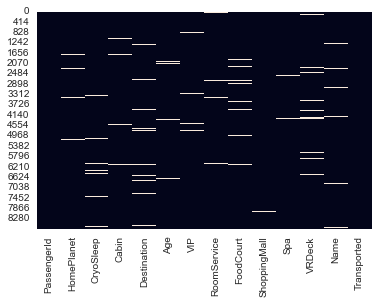

In [70]:
# Plot heatmap of null values and calculate proportion of records with at least one null value
sns.heatmap(train_full.isnull(), cbar=False)
1 - len(train_full.dropna(axis=0)) / len(train_full)


# Name
As previously mentioned, the unique nature of the Name column means that it is of little value in terms of classification; however, that does not mean the column is useless altogether. To the contrary, we can use the pitfall of this column to leverage information about duplicate records. Specifically, we can assume that any non-NaN values that are not unique in this column indicates a record that has been duplicated erroneously. In this way, we will prune the dataset of any repeats.


In [71]:
# Number of records with null 'Name'
train_full['Name'].isnull().sum()

200


In the above cell, we can see that we have 200 passengers with corrupted Name data. In the cell below, we can see that we have 8473 unique values in the Name column. These two facts, combined with the size of our data set (8693), we can say that 20 of our records are duplicates in the Name column and should therefore be purged.

In [72]:
# Number of unique 'Name' values
train_full['Name'].value_counts().count()

8473

In [73]:
non_nan_df = train_full.dropna(subset=['Name'])
nan_df = train_full[train_full['Name'].isna()]

# Remove duplicates from the non-NaN dataframe, keeping the first occurrence
non_nan_df.drop_duplicates(subset='Name', keep='first', inplace=True)

# Concatenate the two dataframes back together
train_full = pd.concat([non_nan_df, nan_df], ignore_index=True)

C:\Users\madse\AppData\Local\Temp\ipykernel_6436\2948561282.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_df.drop_duplicates(subset='Name', keep='first', inplace=True)


# Home Planet
This is some text.


In [74]:
agg_homeplanet=train_full.groupby(['HomePlanet', 'Transported'])['HomePlanet'].count().unstack().fillna(0)
agg_homeplanet=agg_homeplanet.assign(Proportion_Transported=agg_homeplanet[True] / (agg_homeplanet[True] + agg_homeplanet[False]))
agg_homeplanet

Transported,False,True,Proportion_Transported
HomePlanet,,,
Earth,2644,1945,0.423840
Europa,726,1401,0.658674
Mars,837,919,0.523349


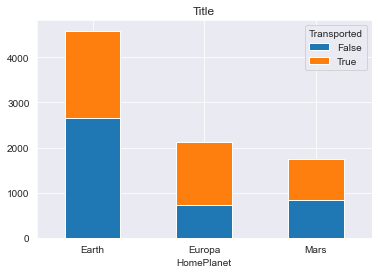

In [75]:
agg_homeplanet=train_full.groupby(['HomePlanet', 'Transported'])['HomePlanet'].count().unstack().fillna(0)
agg_homeplanet.plot(kind='bar', stacked=True)
plt.title('Title')
plt.xticks(rotation=0, ha='center')
plt.show();

# CryoSleep
This is some text.


In [76]:
agg_cryosleep=train_full.groupby(['CryoSleep', 'Transported'])['CryoSleep'].count().unstack().fillna(0)
agg_cryosleep=agg_cryosleep.assign(Proportion_Transported=agg_cryosleep[True] / (agg_cryosleep[True] + agg_cryosleep[False]))
agg_cryosleep

Transported,False,True,Proportion_Transported
CryoSleep,,,
False,3641,1785,0.328972
True,553,2477,0.817492


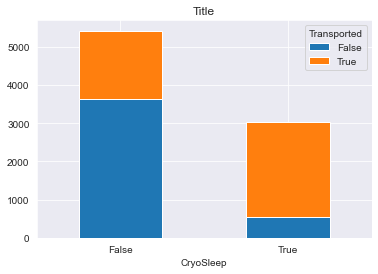

In [77]:
agg_cryosleep=train_full.groupby(['CryoSleep', 'Transported'])['CryoSleep'].count().unstack().fillna(0)
agg_cryosleep.plot(kind='bar', stacked=True)
plt.title('Title')
plt.xticks(rotation=0, ha='center')
plt.show();

# Destination
This is some more text.


In [78]:
agg_destination=train_full.groupby(['Destination', 'Transported'])['Destination'].count().unstack().fillna(0)
agg_destination=agg_destination.assign(Proportion_Transported=agg_destination[True] / (agg_destination[True] + agg_destination[False]))
agg_destination

Transported,False,True,Proportion_Transported
Destination,,,
55 Cancri e,700,1095,0.610028
PSO J318.5-22,393,401,0.505038
TRAPPIST-1e,3122,2780,0.471027


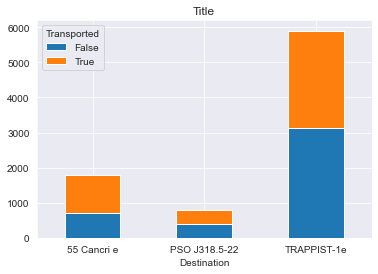

In [79]:
agg_destination=train_full.groupby(['Destination', 'Transported'])['Destination'].count().unstack().fillna(0)
agg_destination.plot(kind='bar', stacked=True)
plt.title('Title')
plt.xticks(rotation=0, ha='center')
plt.show();

# VIP
This is some VIP text.


In [80]:
agg_vip=train_full.groupby(['VIP', 'Transported'])['VIP'].count().unstack().fillna(0)
agg_vip=agg_vip.assign(Proportion_Transported=agg_vip[True] / (agg_vip[True] + agg_vip[False]))
agg_vip

Transported,False,True,Proportion_Transported
VIP,,,
False,4083,4188,0.506347
True,123,76,0.381910


(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

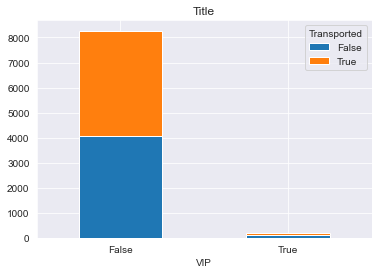

In [81]:
agg_vip=train_full.groupby(['VIP', 'Transported'])['VIP'].count().unstack().fillna(0)
agg_vip.plot(kind='bar', stacked=True)
plt.title('Title')
plt.xticks(rotation=0, ha='center')

# Age
This is some more text.

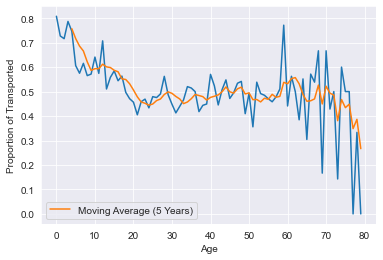

In [82]:
grouped = train_full.groupby('Age')['Transported'].mean()
rolling_mean = grouped.rolling(window=5).mean()

# plot the result
sns.lineplot(x=grouped.index, y=grouped.values)
sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, label='Moving Average (5 Years)')

# set x and y labels
plt.xlabel('Age')
plt.ylabel('Proportion of Transported')

# show plot
plt.show()

## Feature Engineering

We will begin the process of creating our final training set by creating additional features and pruning some others. Both the 'PassengerId' and 'Cabin' features are somewhat confounded, with these features being multiple pieces of information concatenated together. We will parse the first four characters from the 'PassengerId' field to create a column identifying each passenger's group. Then, using this newly created column, we will create a different column specifying the size of each passenger's group. The distribution of group size can be found below:


In [83]:
train_full['group'] = train_full['PassengerId'].str[:4]
train_full['group_size'] = train_full.groupby('group')['group'].transform('count')
train_full['group_size'].value_counts()

1    4796
2    1676
3    1017
4     416
5     265
7     231
6     168
8     104
Name: group_size, dtype: int64

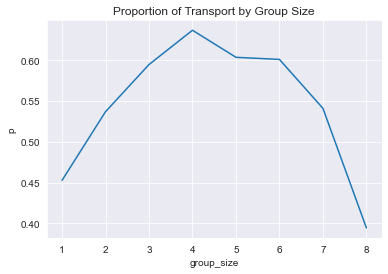

In [84]:
train_full.groupby('group_size')['Transported'].mean().plot(kind='line')
plt.title('Proportion of Transport by Group Size')
plt.ylabel('p')
plt.show();

From the plot above, we can see that this new feature of 'group_size' appears to be a good predictor of Transport. Specifically, it appears that for the largest groups and solo/duo groups the probability of being transported is lower than the probability of transport for groups of 3 to 6 people.

Next, we will extract the side of the ship that each passenger stayed on, as well as the deck they stayed on, by parsing through the 'Cabin' field and taking off each bookend. There are 8 unique values for 'deck', and we have approximate balance between the port and starboard sides of the ship. We extracted the room number for each passenger, but unfortunately there are too many unique values (1817) for it to be a reasonable feature.

In [85]:
train_full['deck'] = train_full['Cabin'].str[:1]
train_full['deck'].value_counts()

F    2786
G    2552
E     875
B     778
C     745
D     478
A     256
T       5
Name: deck, dtype: int64

In [86]:
train_full['side'] = train_full['Cabin'].str[-1:]
train_full['side'].value_counts()

S    4279
P    4196
Name: side, dtype: int64

In [87]:
train_full['Cabin'].str.extract(r'\/(.*?)\/').value_counts().count()

1815

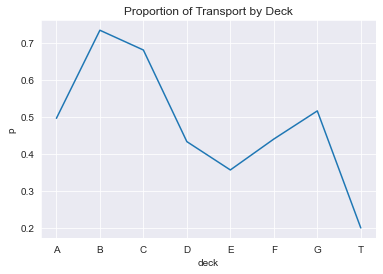

In [88]:
train_full.groupby('deck')['Transported'].mean().plot(kind='line')
plt.title('Proportion of Transport by Deck')
plt.ylabel('p')
plt.show();

In the above plot, we can see that the proportion of our training set that were transported depended significantly upon the level of 'deck'. In the plot below, we can see that the proportion of our training set that were transported depended upon the which side of the ship the passenger was staying on. Together, they reinforce the features we have created as we are more confident that they will be significant predictors in our classification model.

Text(0, 0.5, 'p')

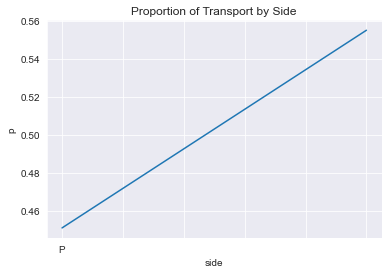

In [89]:
train_full.groupby('side')['Transported'].mean().plot(kind='line')
plt.title('Proportion of Transport by Side')
plt.ylabel('p')

In [90]:
train_full['total_spent'] = train_full[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
sum(train_full.total_spent[train_full.CryoSleep == 1])

0.0

## Imputation
This is some text.

In [91]:
train = train_full.drop(['PassengerId', 'Cabin', 'Name', 'group', 'total_spent'], axis=1)

In [92]:
null_values = pd.DataFrame(train.isna().sum(), columns=['Number of NaN Values'])
print(null_values)

              Number of NaN Values
HomePlanet                     201
CryoSleep                      217
Destination                    182
Age                            179
VIP                            203
RoomService                    181
FoodCourt                      183
ShoppingMall                   208
Spa                            183
VRDeck                         188
Transported                      0
group_size                       0
deck                           198
side                           198


In [93]:
to_impute = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Impute the missing values in the specified columns with the median value
for col in to_impute:
    train[col].fillna(train[col].median(), inplace=True)

In [94]:
train['HomePlanet'] = train['HomePlanet'].astype('category')
train['CryoSleep'] = train['CryoSleep'].astype('category')
train['Destination'] = train['Destination'].astype('category')
train['VIP'] = train['VIP'].astype('category')
train['Transported'] = train['Transported'].astype('category')
train['deck'] = train['deck'].astype('category')
train['side'] = train['side'].astype('category')

train['HomePlanet'] = train['HomePlanet'].cat.codes
train['CryoSleep'] = train['CryoSleep'].cat.codes
train['Destination'] = train['Destination'].cat.codes
train['VIP'] = train['VIP'].cat.codes
train['Transported'] = train['Transported'].cat.codes
train['deck'] = train['deck'].cat.codes
train['side'] = train['side'].cat.codes

In [95]:
mask = train['CryoSleep'] == -1
totalsum = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

train.loc[mask & (totalsum == 0), 'CryoSleep'] = 1
train.loc[mask & (totalsum > 0), 'CryoSleep'] = 0

In [96]:
train['CryoSleep'].value_counts()

0    5545
1    3128
Name: CryoSleep, dtype: int64

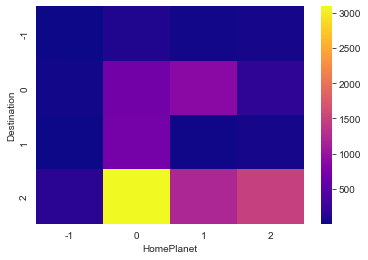

In [97]:
cat_pivot = train.groupby(['HomePlanet', 'Destination']).size()
cat_pivot = cat_pivot.reset_index(name = 'count')
cat_pivot = cat_pivot.pivot(index = 'Destination', columns = 'HomePlanet', values = 'count')
sns.heatmap(cat_pivot, cmap='plasma');

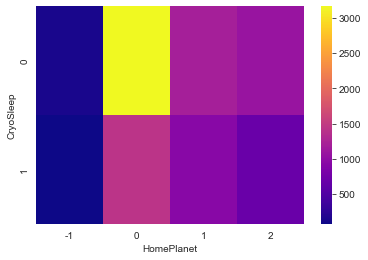

In [98]:
cat_pivot = train.groupby(['HomePlanet', 'CryoSleep']).size()
cat_pivot = cat_pivot.reset_index(name = 'count')
cat_pivot = cat_pivot.pivot(index = 'CryoSleep', columns = 'HomePlanet', values = 'count')
sns.heatmap(cat_pivot, cmap='plasma');

Passengers from HomePlanet 1 were pretty equally split between Destination 0 and 2, and this was irrespective of any further slicing of the data. We can see from above that if a passenger was not in cryosleep, it was much more likely that the passenger was from planet0. Likewise, if a passenger was in cryosleep, it was much more likely that the passenger was from planet 1.

In [99]:
mask = train['Destination'] == -1
homeplanet_temp = train['HomePlanet']

train.loc[mask & (homeplanet_temp == -1), 'Destination'] = 2
train.loc[mask & (homeplanet_temp == 0), 'Destination'] = 2
train.loc[mask & (homeplanet_temp == 1), 'Destination'] = random.choice([0, 2])
train.loc[mask & (homeplanet_temp == 2), 'Destination'] = 2

In [100]:
mask = train['HomePlanet'] == -1
cryosleep_temp = train['CryoSleep']

train.loc[mask & (cryosleep_temp == 0), 'HomePlanet'] = 0
train.loc[mask & (cryosleep_temp == 1), 'HomePlanet'] = 1

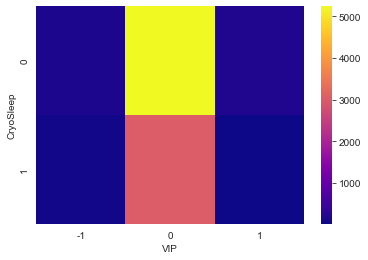

In [101]:
cat_pivot = train.groupby(['VIP', 'CryoSleep']).size()
cat_pivot = cat_pivot.reset_index(name = 'count')
cat_pivot = cat_pivot.pivot(index = 'CryoSleep', columns = 'VIP', values = 'count')
sns.heatmap(cat_pivot, cmap = 'plasma');

In [102]:
mask = train['VIP'] == -1
train.loc[mask, 'VIP'] = 0

This is text.

In [103]:
train['deck'] = train['deck'].where(train['deck'] != -1, npy.nan)
mode_deck = train['deck'].mode().values[0]
train['side'] = train['side'].where(train['side'] != -1, npy.nan)
mode_side = train['side'].mode().values[0]

# Impute the missing values with the mode
train['deck'] = train['side'].fillna(mode_deck)
train['side'] = train['side'].fillna(mode_side)

In [104]:
train['HomePlanet'] = train['HomePlanet'].astype('category')
train['CryoSleep'] = train['HomePlanet'].astype('category')
train['Destination'] = train['HomePlanet'].astype('category')
train['VIP'] = train['HomePlanet'].astype('category')
train['deck'] = train['HomePlanet'].astype('category')
train['side'] = train['HomePlanet'].astype('category')

In [105]:
test_full['group'] = test_full['PassengerId'].str[:4]
test_full['group_size'] = test_full.groupby('group')['group'].transform('count')
test_full['group_size'].value_counts()

test_full['deck'] = test_full['Cabin'].str[:1]
test_full['deck'].value_counts()

test_full['side'] = test_full['Cabin'].str[-1:]
test_full['side'].value_counts()

to_impute = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Impute the missing values in the specified columns with the median value
for col in to_impute:
    test_full[col].fillna(test_full[col].median(), inplace=True)

test=test_full.drop(['PassengerId', 'Cabin', 'Name', 'group'], axis=1)

test['HomePlanet'] = test['HomePlanet'].astype('category')
test['CryoSleep'] = test['CryoSleep'].astype('category')
test['Destination'] = test['Destination'].astype('category')
test['VIP'] = test['VIP'].astype('category')
test['deck'] = test['deck'].astype('category')
test['side'] = test['side'].astype('category')

test['HomePlanet'] = test['HomePlanet'].cat.codes
test['CryoSleep'] = test['CryoSleep'].cat.codes
test['Destination'] = test['Destination'].cat.codes
test['VIP'] = test['VIP'].cat.codes
test['deck'] = test['deck'].cat.codes
test['side'] = test['side'].cat.codes

mask = test['CryoSleep'] == -1
totalsum = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

test.loc[mask & (totalsum == 0), 'CryoSleep'] = 1
test.loc[mask & (totalsum > 0), 'CryoSleep'] = 0

mask = test['Destination'] == -1
homeplanet_temp = test['HomePlanet']

test.loc[mask & (homeplanet_temp == -1), 'Destination'] = 2
test.loc[mask & (homeplanet_temp == 0), 'Destination'] = 2
test.loc[mask & (homeplanet_temp == 1), 'Destination'] = random.choice([0, 2])
test.loc[mask & (homeplanet_temp == 2), 'Destination'] = 2

mask = test['HomePlanet'] == -1
cryosleep_temp = test['CryoSleep']

test.loc[mask & (cryosleep_temp == 0), 'HomePlanet'] = 0
test.loc[mask & (cryosleep_temp == 1), 'HomePlanet'] = 1

mask = test['VIP'] == -1
test.loc[mask, 'VIP'] = 0

test['deck'] = test['deck'].where(test['deck'] != -1, npy.nan)
mode_deck = test['deck'].mode().values[0]
test['side'] = test['side'].where(test['side'] != -1, npy.nan)
mode_side = test['side'].mode().values[0]

# Impute the missing values with the mode
test['deck'] = test['side'].fillna(mode_deck)
test['side'] = test['side'].fillna(mode_side)

test['HomePlanet'] = test['HomePlanet'].astype('category')
test['CryoSleep'] = test['HomePlanet'].astype('category')
test['Destination'] = test['HomePlanet'].astype('category')
test['VIP'] = test['HomePlanet'].astype('category')
test['deck'] = test['HomePlanet'].astype('category')
test['side'] = test['HomePlanet'].astype('category')

In [106]:
X = train_redacted.drop(['PassengerId', 'Transported', 'Name', 'Cabin'], axis=1)
y = train_redacted['Transported'].astype(int).to_list()

to_impute = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Impute the missing values in the specified columns with the median value
for col in to_impute:
    X[col].fillna(X[col].median(), inplace=True)

X['HomePlanet'] = X['HomePlanet'].astype('category')
X['CryoSleep'] = X['CryoSleep'].astype('category')
X['Destination'] = X['Destination'].astype('category')
X['VIP'] = X['VIP'].astype('category')

X['HomePlanet'] = X['HomePlanet'].cat.codes
X['CryoSleep'] = X['CryoSleep'].cat.codes
X['Destination'] = X['Destination'].cat.codes
X['VIP'] = X['VIP'].cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Evaluate the model on the test data
print("Test accuracy: {:.2f}%".format(logreg.score(X_test, y_test) * 100))

Test accuracy: 77.72%


C:\Users\madse\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
X_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4737,2,1,2,42.0,0,0.0,0.0,0.0,0.0,0.0
1688,1,1,0,33.0,0,0.0,0.0,0.0,0.0,0.0
3205,0,0,2,29.0,0,0.0,4.0,0.0,0.0,904.0
5859,2,0,2,27.0,1,55.0,0.0,50.0,1849.0,1.0
3956,2,0,2,32.0,0,1331.0,416.0,0.0,665.0,64.0
...,...,...,...,...,...,...,...,...,...,...
4984,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0
6864,0,0,1,22.0,0,28.0,194.0,2.0,0.0,370.0
6919,1,0,2,25.0,0,0.0,115.0,0.0,1823.0,4041.0
7137,1,0,0,40.0,1,0.0,21.0,0.0,1503.0,1392.0


In [108]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']
numeric_cols = ['Age', 'group_size', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_data = train[numeric_cols].to_numpy()

# Normalize the numeric data
normalizer = Normalizer()
normalized_numeric_data = normalizer.fit_transform(numeric_data)
normalized_numeric_data = pd.DataFrame(normalized_numeric_data)

ohe = OneHotEncoder(handle_unknown='ignore')
train_cat_ohe = pd.DataFrame(ohe.fit_transform(train[categorical_cols]).toarray(), columns=ohe.get_feature_names_out(categorical_cols))

train_cat_ohe = train_cat_ohe.astype(int).to_numpy()
X = npy.hstack([normalized_numeric_data, train_cat_ohe])
y = train['Transported']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Define the models to be used
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    xgb.XGBClassifier()
]

# Train and evaluate each model
results =[]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    results.append([model.__class__.__name__, accuracy, recall, precision, f1, auc_roc])

# Display the results in a table format
print("| Model | Accuracy | Recall | Precision | F1 | AUC-ROC |")
print("|-------|----------|--------|----------|----|---------|")
for result in results:
    print(f"| {result[0]} | {result[1]:.2f} | {result[2]:.2f} | {result[3]:.2f} | {result[4]:.2f} | {result[5]:.2f} |")

| Model | Accuracy | Recall | Precision | F1 | AUC-ROC |
|-------|----------|--------|----------|----|---------|
| LogisticRegression | 0.79 | 0.88 | 0.74 | 0.80 | 0.78 |
| KNeighborsClassifier | 0.75 | 0.75 | 0.75 | 0.75 | 0.75 |
| DecisionTreeClassifier | 0.71 | 0.78 | 0.69 | 0.73 | 0.71 |
| RandomForestClassifier | 0.77 | 0.80 | 0.76 | 0.78 | 0.77 |
| SVC | 0.78 | 0.89 | 0.73 | 0.80 | 0.78 |
| XGBClassifier | 0.78 | 0.82 | 0.75 | 0.79 | 0.78 |


In [115]:
space = {
    'max_depth': Integer(3, 7),
    'learning_rate': Real(10**-5, 10**0, prior='log-uniform'),
    'n_estimators': Integer(50, 200),
    'min_child_weight': Integer(2, 100),
    'gamma': Real(10**-5, 10**0, prior='log-uniform'),
    'subsample': Real(10**-5, 10**0, prior='log-uniform'),
    'reg_lambda': Real(10**-7, 10**-2, prior='log-uniform'),
    'reg_alpha': Real(10**-7, 10**-2, prior='log-uniform')
}

# Define the XGBoost model and the search strategy, n_jobs sets number of threads used -1 is all
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1)
opt = BayesSearchCV(xgb_model, search_spaces=space, n_iter=100, cv=10, random_state=42)

# Fit the model and find the best hyperparameters
opt.fit(X_train, y_train)

# Evaluate the model on the test set
score = opt.score(X_test, y_test)

# Print the best hyperparameters and test accuracy
print("Best hyperparameters: ", opt.best_params_)
print("Test accuracy: ", score)


KeyboardInterrupt: 

In [111]:
best_params = opt.best_params_

# Train a new XGBoost model using the best hyperparameters on the full training set
model = xgb.XGBClassifier(max_depth=best_params['max_depth'],
                           learning_rate=best_params['learning_rate'],
                           n_estimators=best_params['n_estimators'],
                           subsample=best_params['subsample'],
                           gamma=best_params['gamma'],
                           min_child_weight=best_params['min_child_weight'],
                           reg_alpha=best_params['reg_alpha'],
                           reg_lambda=best_params['reg_lambda'])
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10485796387886125,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=45, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [112]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']
categorical_data = test[categorical_cols]
numeric_cols = ['Age', 'group_size', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_data = test[numeric_cols].to_numpy()

normalized_numeric_data = normalizer.fit_transform(numeric_data)
normalized_numeric_data = pd.DataFrame(normalized_numeric_data)

ohe = OneHotEncoder(handle_unknown='ignore')
test_cat_ohe = pd.DataFrame(ohe.fit_transform(test[categorical_cols]).toarray(), columns=ohe.get_feature_names_out(categorical_cols))

test_cat_ohe = test_cat_ohe.astype(int).to_numpy()
X_final_test = npy.hstack([normalized_numeric_data, test_cat_ohe])

# Make predictions on the test set
y_pred = model.predict(X_final_test)

In [114]:
test_pid = test_full.PassengerId.to_list()
str_pred = []
for pred in y_pred:
    if pred == 0:
        str_pred.append('False')
    if pred == 1:
        str_pred.append('True')

pred_df = pd.DataFrame({'PassengerId': test_pid, 'Transported': str_pred})
pred_df.to_csv('spaceship_predictions.csv', index = False)